#**Random Forest**
---
##Author: Emmanuel Paalam
##V3: SMOTE-oversampled data used, all solvers/transformers tested
##Target variable: F3EVERDO

## Import data

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Load the transformed data
X_train = np.load('/content/drive/My Drive/research/SURP 2024/colab/data/cleaned/X_train_SMOTE.5.npy')
X_test = np.load('/content/drive/My Drive/research/SURP 2024/colab/data/cleaned/X_test_SMOTE.5.npy')
y_train = np.load('/content/drive/My Drive/research/SURP 2024/colab/data/cleaned/y_train_SMOTE.5.npy')
y_test = np.load('/content/drive/My Drive/research/SURP 2024/colab/data/cleaned/y_test_SMOTE.5.npy')

# Load the feature names (optional)
with open('/content/drive/My Drive/research/SURP 2024/colab/data/cleaned/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f]

print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

(14125, 211), (2624, 211), (14125,), (2624,)


##Model development

###Define parameters, scoring

In [3]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [10, 30, 90]
    }

In [4]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

In [5]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'specificity': make_scorer(specificity_score),
    'npv': make_scorer(npv_score)
}

###Cross-validate

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

grid_search = GridSearchCV(RandomForestClassifier(random_state=2030), param_grid=param_grid, scoring=scoring, refit='f1', cv=StratifiedKFold(n_splits=5), n_jobs=-1, return_train_score=True)

In [23]:
grid_search.fit(X_train, y_train)

# Access and print the cv_results_
results = grid_search.cv_results_

In [24]:
# Print the relevant metrics
print("Mean Test Accuracy:", results['mean_test_accuracy'])
print("Mean Test Precision:", results['mean_test_precision'])
print("Mean Test Recall:", results['mean_test_recall'])
print("Mean Test F1:", results['mean_test_f1'])
print("Mean Test Specificity:", results['mean_test_specificity'])
print("Mean Test NPV:", results['mean_test_npv'])

Mean Test Accuracy: [0.94838938 0.94654867 0.94123894 0.94782301 0.94541593 0.94230088
 0.94782301 0.94541593 0.94230088]
Mean Test Precision: [0.9616661  0.95881537 0.952632   0.96159087 0.95850226 0.95258288
 0.96159087 0.95850226 0.95258288]
Mean Test Recall: [0.92875129 0.92662792 0.92046985 0.92768899 0.92476888 0.92238184
 0.92768899 0.92476888 0.92238184]
Mean Test F1: [0.93161274 0.930024   0.92434176 0.93059323 0.92809106 0.92601257
 0.93059323 0.92809106 0.92601257]
Mean Test Specificity: [0.98757449 0.98630038 0.98268934 0.98799923 0.98661874 0.98205246
 0.98799923 0.98661874 0.98205246]
Mean Test NPV: [0.94836422 0.94640005 0.94174541 0.94742675 0.94498569 0.94349323
 0.94742675 0.94498569 0.94349323]


In [25]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

Best parameters found:  {'criterion': 'gini', 'min_samples_split': 10}
Best cross-validation score: 0.93


### Observe metrics

Accuracy: 0.9516006097560976
Precision: 0.8864864864864865
Recall: 0.6074074074074074
F1 Score: 0.720879120879121
ROC-AUC: 0.9610764970578056
Specificity: 0.9910790144435004
Test Negative Predictive Value (NPV): 0.956539565395654
Confusion Matrix:
[[2333   21]
 [ 106  164]]


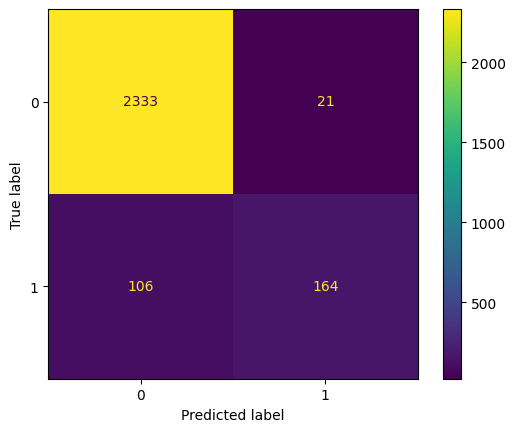

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate test negative predictive value (NPV)
test_npv = tn / (tn + fn)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Specificity: {specificity}")
print(f'Test Negative Predictive Value (NPV): {test_npv}')
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot()

##Tree visual

In [27]:
import numpy as np

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_std = std[indices]

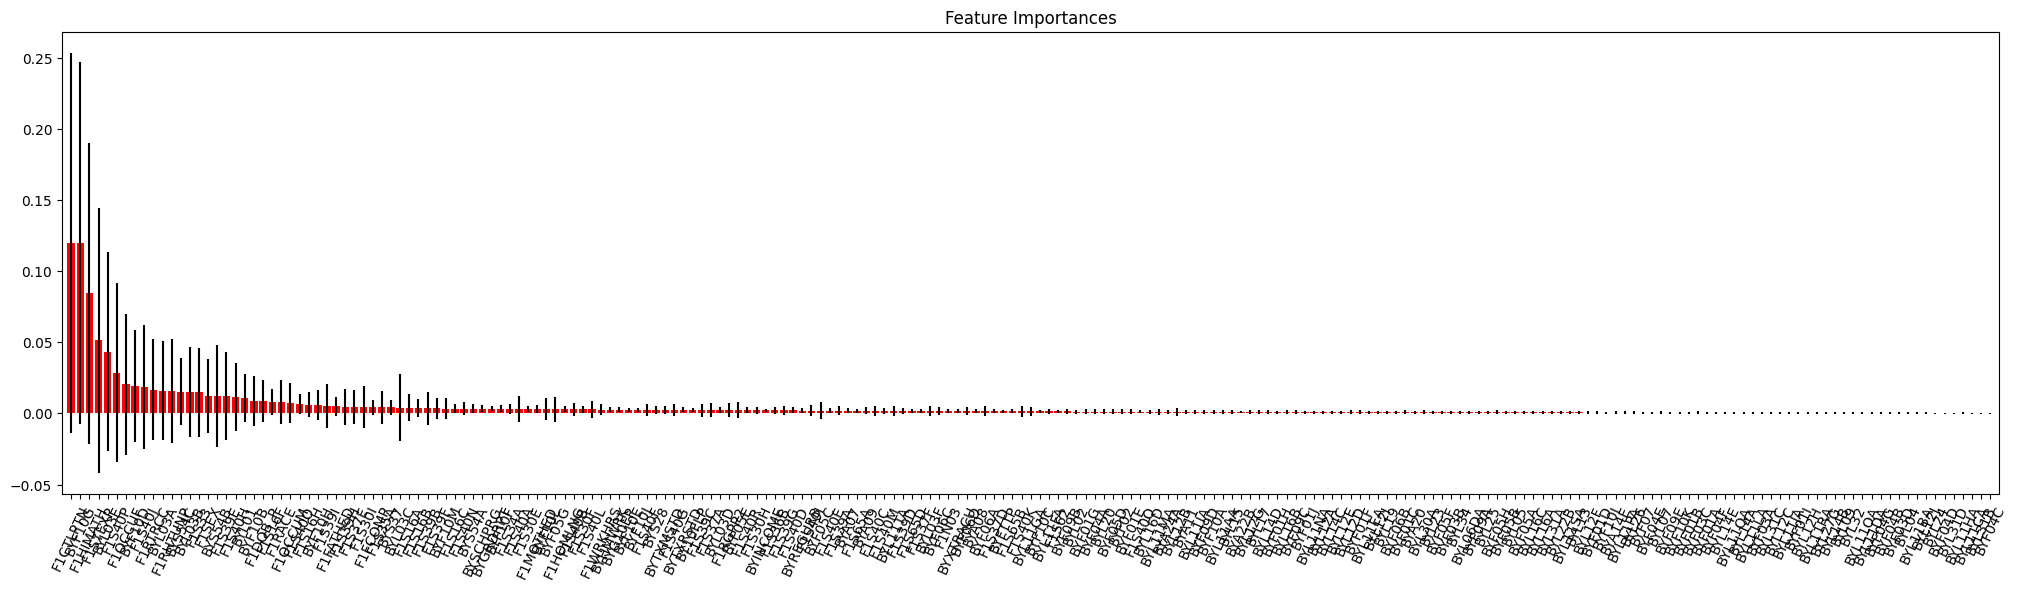

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), sorted_importances, color="r", yerr=sorted_std, align="center")
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=65)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [29]:
top_features = [feature_names[i] for i in indices[:15]]
print(f"15th most important features: {top_features}")

15th most important features: ['F1CTLPTN', 'BYF10G', 'F1HIMATH', 'F1STEXP', 'BYL03E', 'F1S40P', 'F1OCCUF', 'BYF10D', 'F1S40J', 'F1RTRCC', 'BYL03A', 'F1RHTUNP', 'BYS54C', 'BYL03B', 'F1S33']
